In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *
pd.set_option('display.float_format', '{:.6f}'.format)

In [189]:
# hardcoded stuff
df_path = "data/otu_table_example.csv"
metadata_path = "data/metadata_example.csv"

## Data

## All patients together

In [212]:
def feats_and_targets(df, seq_length):
    
    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")

    test_subject_idx = np.random.randint(0, len(subjects))
    test_subject = subjects[test_subject_idx]
    subjects = np.delete(subjects, test_subject_idx)
    
    print(f"The test subject is {test_subject}")

    train_feats = []
    train_targets = []
    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = cut_to_sequences(subject_df, seq_length=seq_length)

        for sequence_idx in range(len(subject_feats)):
            train_feats.append(subject_feats[sequence_idx])
            train_targets.append(subject_targets[sequence_idx])
            
    test_subject_df = df_subject_grp.get_group(test_subject).drop(columns=["subject_id"])
    test_feats, test_targets = cut_to_sequences(test_subject_df, seq_length=seq_length)
    
    # shuffle the train features and targets
    random_order = np.random.permutation(len(train_feats))
    
    train_feats = np.asarray(train_feats)[random_order]
    train_targets = np.asarray(train_targets)[random_order]
    
    # do not shuffle the test set
    test_feats = np.asarray(test_feats)
    test_targets = np.asarray(test_targets)

    return train_feats, train_targets, test_feats, test_targets

In [213]:
max_zeros_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [214]:
train_feats, train_targets, test_feats, test_targets = feats_and_targets(df, seq_length=sequence_length)

The test subject is E010481


In [215]:
print(train_feats.shape)
print(train_targets.shape)

(297, 10, 204)
(297, 204)


In [216]:
print(test_feats.shape)
print(test_targets.shape)

(22, 10, 204)
(22, 204)


In [217]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.1)

n_feats = len(df.columns) - 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1024)              5033984   
                                                                 
 dense_26 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_27 (Dense)            (None, 204)               417996    
                                                                 
Total params: 7551180 (28.81 MB)
Trainable params: 7551180 (28.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [218]:
model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=30)

Epoch 1/30
9/9 [==============================] - 2s 35ms/step - loss: 25.9325 - mae: 0.0950 - mape: 2546773.0000 - val_loss: 22.8200 - val_mae: 0.0907 - val_mape: 998479.0625
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 20.3219 - mae: 0.0798 - mape: 1442646.6250 - val_loss: 18.8230 - val_mae: 0.0856 - val_mape: 815900.0625
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 16.4968 - mae: 0.0722 - mape: 1093231.5000 - val_loss: 15.1554 - val_mae: 0.0736 - val_mape: 1026893.0625
Epoch 4/30
9/9 [==============================] - 0s 14ms/step - loss: 13.7816 - mae: 0.0661 - mape: 968644.3125 - val_loss: 13.3309 - val_mae: 0.0718 - val_mape: 1026652.9375
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 11.9911 - mae: 0.0626 - mape: 754169.1875 - val_loss: 11.6186 - val_mae: 0.0661 - val_mape: 1144664.3750
Epoch 6/30
9/9 [==============================] - 0s 15ms/step - loss: 10.7006 - mae: 0.0596 - mape: 764041.5625 - val_

In [219]:
y_pred = model.predict(test_feats)

1/1 [==============================] - 0s 94ms/step


In [220]:
y_test_df = pd.DataFrame(test_targets)
y_pred_df = pd.DataFrame(y_pred)

In [221]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 29, 14.215686274509803% of all taxa


In [222]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.007167,0.000040,0.155556,0.101179,0.051036,0.072816,0.033333,0.190476,0.082224,0.295302,...,0.000160,0.176471,0.000909,0.050879,0.012658,0.032878,0.040271,0.172414,0.302594,0.302594
1,0.018106,0.006806,0.133333,0.099938,0.015533,0.072816,0.030769,0.095238,0.084954,0.201342,...,0.000107,0.264706,0.000227,0.042085,0.012658,0.068351,0.071638,0.093596,0.354467,0.354467
2,0.143342,0.090618,0.111111,0.104283,0.015533,0.199029,0.051282,0.166667,0.169908,0.161074,...,0.015789,0.205882,0.000454,0.117672,0.063291,0.176847,0.099913,0.088670,0.394813,0.394813
3,0.262542,0.091999,0.066667,0.009932,0.017751,0.208738,0.079487,0.119048,0.176390,0.134228,...,0.015709,0.205882,0.048050,0.134841,0.056962,0.223568,0.131405,0.019704,0.412104,0.412104
4,0.265183,0.099005,0.133333,0.009311,0.017751,0.291262,0.087179,0.095238,0.180143,0.107383,...,0.015763,0.117647,0.062591,0.170226,0.075949,0.263194,0.154211,0.019704,0.446686,0.446686
5,0.158054,0.015273,0.088889,0.002483,0.017751,0.189320,0.056410,0.023810,0.095189,0.147651,...,0.000053,0.117647,0.062477,0.091709,0.025316,0.154352,0.107911,0.014778,0.475504,0.475504
6,0.097322,0.039554,0.288889,0.000000,0.000000,0.179612,0.197436,0.047619,0.032412,0.120805,...,0.000053,0.117647,0.014682,0.204774,0.025316,0.341928,0.277306,0.014778,0.504323,0.504323
7,0.141456,0.032708,0.288889,0.000000,0.000000,0.058252,0.217949,0.071429,0.044012,0.174497,...,0.000000,0.205882,0.000114,0.201843,0.025316,0.350061,0.303330,0.019704,0.536023,0.536023
8,0.146360,0.037372,0.355556,0.000000,0.000000,0.087379,0.264103,0.071429,0.047765,0.161074,...,0.000027,0.147059,0.000000,0.259003,0.025316,0.437619,0.357004,0.009852,0.550432,0.550432
9,0.114296,0.019817,0.266667,0.013035,0.001479,0.092233,0.135897,0.023810,0.070283,0.127517,...,0.000027,0.088235,0.000028,0.148869,0.044304,0.264060,0.224944,0.004926,0.587896,0.587896


In [223]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.008697,0.000000,0.129597,0.000000,0.024743,0.070157,0.040995,0.182603,0.004429,0.182421,...,0.000000,0.151743,0.000000,0.092320,0.084984,0.081485,0.126321,0.274938,0.394218,0.388820
1,0.016820,0.000000,0.132442,0.000000,0.040455,0.087643,0.044491,0.233796,0.004404,0.239990,...,0.000000,0.195580,0.000000,0.093238,0.091780,0.085183,0.118086,0.308161,0.419992,0.415221
2,0.017266,0.000000,0.120901,0.000000,0.044588,0.079141,0.051500,0.234659,0.008658,0.246072,...,0.000000,0.193108,0.000000,0.094079,0.083214,0.084268,0.105805,0.297351,0.431202,0.426585
3,0.032829,0.000000,0.113667,0.000000,0.042011,0.081283,0.054827,0.246733,0.021799,0.252534,...,0.000000,0.204957,0.000000,0.100839,0.077372,0.086994,0.107869,0.298484,0.456190,0.450822
4,0.033461,0.000000,0.094063,0.000000,0.038055,0.067851,0.066084,0.225444,0.033999,0.238882,...,0.000000,0.186477,0.000000,0.110108,0.059765,0.090131,0.105398,0.270880,0.479005,0.473443
5,0.039980,0.000000,0.084486,0.000000,0.044106,0.077621,0.074572,0.226077,0.039658,0.253604,...,0.000000,0.192238,0.000000,0.123374,0.055796,0.097210,0.091064,0.258281,0.525623,0.521821
6,0.029969,0.000000,0.073071,0.000000,0.039383,0.068848,0.071804,0.199666,0.037797,0.238059,...,0.000000,0.168845,0.000000,0.114904,0.049774,0.093046,0.073301,0.229669,0.533777,0.531458
7,0.023257,0.000000,0.092171,0.000000,0.041624,0.072713,0.105333,0.191323,0.055276,0.226636,...,0.000000,0.168697,0.000000,0.158044,0.046549,0.125243,0.108609,0.212784,0.551206,0.551015
8,0.027828,0.000000,0.117079,0.000000,0.038887,0.075176,0.135953,0.195768,0.074868,0.223665,...,0.000000,0.180173,0.000000,0.196578,0.046928,0.153428,0.152760,0.200729,0.577052,0.578452
9,0.030393,0.000000,0.132790,0.000000,0.041317,0.084189,0.162782,0.201852,0.088257,0.226536,...,0.000000,0.190726,0.000000,0.232693,0.046166,0.179949,0.187278,0.190199,0.605656,0.609072


In [224]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.716404,1.000000,0.478468,0.863636,54497331.156684,0.396775,0.735929,303208910.907913,0.384031,6.148727,...,0.590908,189220885.890496,0.954545,0.920848,1.675306,0.524514,0.465108,72660799.078091,0.174545,0.170138
std,0.220746,0.000001,0.297779,0.351250,140448165.886399,0.300869,0.724505,660280007.310841,0.327173,10.253164,...,0.503236,487636248.206863,0.213201,0.726175,2.442428,0.358499,0.484308,340809320.386380,0.118844,0.119122
min,0.071072,0.999998,0.006682,0.000000,0.395186,0.036510,0.004240,0.041336,0.028042,0.191951,...,0.000000,0.004495,0.000000,0.151275,0.042043,0.048714,0.058979,0.594641,0.028325,0.027969
25%,0.702567,1.000000,0.198787,1.000000,1.514620,0.148886,0.307468,1.221695,0.112302,0.423363,...,0.000000,0.191755,1.000000,0.347257,0.153712,0.275845,0.158948,2.413684,0.071028,0.061811
50%,0.811980,1.000000,0.558653,1.000000,4.159663,0.320332,0.468602,1.536932,0.272902,0.813340,...,0.999996,0.705276,1.000000,0.779129,0.909854,0.455788,0.298828,4.034640,0.141583,0.138821
75%,0.844888,1.000000,0.696188,1.000000,14.964046,0.608538,0.730783,6.406581,0.579389,6.598467,...,1.000000,3.341929,1.000000,1.342461,1.767274,0.647608,0.624486,13.797843,0.282818,0.281264
max,0.895714,1.000000,0.892763,1.000000,416238233.447075,1.108320,2.777555,1852106750.011444,0.949042,28.503416,...,1.000000,1444213390.350342,1.000000,2.738182,9.703877,1.478438,2.136764,1598537415.266037,0.363303,0.361506


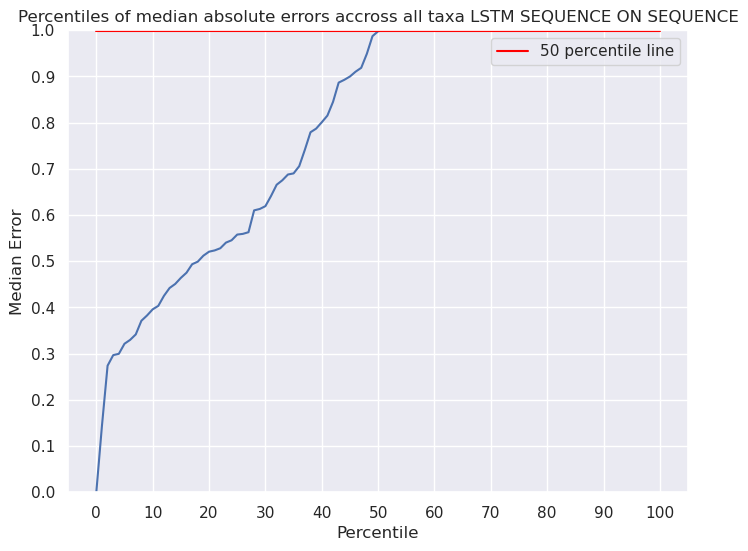

In [225]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=1)

In [226]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,0,2,4,5,6,7,8,9,10,11,...,192,193,195,197,198,199,200,201,202,203
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.716404,0.478468,54497331.156684,0.396775,0.735929,303208910.907913,0.384031,6.148727,116575123.172178,0.871655,...,0.654255,147200192.327695,189220885.890496,0.920848,1.675306,0.524514,0.465108,72660799.078091,0.174545,0.170138
std,0.220746,0.297779,140448165.886399,0.300869,0.724505,660280007.310841,0.327173,10.253164,301642192.379222,0.849242,...,0.686328,241044527.810894,487636248.206863,0.726175,2.442428,0.358499,0.484308,340809320.386380,0.118844,0.119122
min,0.071072,0.006682,0.395186,0.036510,0.004240,0.041336,0.028042,0.191951,0.328530,0.002651,...,0.023001,0.020914,0.004495,0.151275,0.042043,0.048714,0.058979,0.594641,0.028325,0.027969
25%,0.702567,0.198787,1.514620,0.148886,0.307468,1.221695,0.112302,0.423363,0.980659,0.368124,...,0.179413,0.375112,0.191755,0.347257,0.153712,0.275845,0.158948,2.413684,0.071028,0.061811
50%,0.811980,0.558653,4.159663,0.320332,0.468602,1.536932,0.272902,0.813340,2.148920,0.522944,...,0.369771,3.242265,0.705276,0.779129,0.909854,0.455788,0.298828,4.034640,0.141583,0.138821
75%,0.844888,0.696188,14.964046,0.608538,0.730783,6.406581,0.579389,6.598467,9.394432,0.853717,...,0.836856,337251313.030720,3.341929,1.342461,1.767274,0.647608,0.624486,13.797843,0.282818,0.281264
max,0.895714,0.892763,416238233.447075,1.108320,2.777555,1852106750.011444,0.949042,28.503416,932100117.206573,3.030881,...,2.498929,861911177.635193,1444213390.350342,2.738182,9.703877,1.478438,2.136764,1598537415.266037,0.363303,0.361506


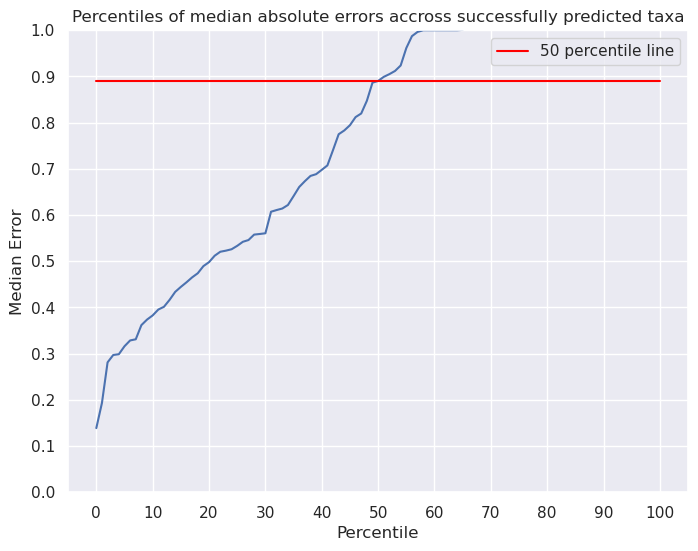

In [227]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)

### A model per each patient?

In [68]:
max_zeros_pct = 0.7
window_size = 3
sequence_length = 10

df = load_and_merge()
subjects = df.subject_id.unique()
print(subjects)

['E000823' 'E001958' 'E003188' 'E003953' 'E004628' 'E004709' 'E004898'
 'E005786' 'E006091' 'E006493' 'E006781' 'E007944' 'E010481' 'E010581'
 'E010682' 'E011878' 'E012854' 'E013094' 'E013505' 'E014086']


In [69]:
df = df[df.subject_id == "E000823"] 

df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

feats, targets = feats_and_targets(df, seq_length=sequence_length)

In [70]:
cutoff = len(feats) - int(np.ceil(len(feats) * .2))

feats_train = feats[:cutoff]
targets_train = targets[:cutoff]

feats_test = feats[cutoff:]
targets_test = targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(feats)}")
print(f"Train sequences: {len(feats_train)}")
print(f"Test sequences: {len(feats_test)}")

Length of data: 24
Total sequences: 14
Train sequences: 11
Test sequences: 3


In [71]:
df_subject_grp = df.groupby("subject_id")

subjects = df.subject_id.unique()

lens = []
non_zero_pcts = []
for subject_idx in tqdm(subjects):
    sub_grp = df_subject_grp.get_group(subject_idx)
    
    sub_grp_len = len(sub_grp)
    lens.append(sub_grp_len)
    
    taxa_non_zero_pcts = pd.Series([len(sub_grp[sub_grp[taxa_idx] != 0]) / sub_grp_len for taxa_idx in sub_grp.columns])
    macro_non_zero_pct = taxa_non_zero_pcts.mean() * 100 # macro averaging!
    non_zero_pcts.append(macro_non_zero_pct)

100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


In [72]:
desc_df = pd.DataFrame()
desc_df["subject"] = subjects
desc_df["n_values"] = lens
desc_df["pct_non_uero_values"] = non_zero_pcts

In [122]:
def feats_and_targets(df, seq_length):
    feats = []
    targets = []

    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")

    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = cut_to_sequences(subject_df, seq_length=seq_length)

        for sequence_idx in range(len(subject_feats)):
            feats.append(subject_feats[sequence_idx])
            targets.append(subject_targets[sequence_idx])

    # shuffle the train features and targets
    random_order = np.random.permutation(len(feats))
    
    feats = np.asarray(feats)[random_order]
    targets = np.asarray(targets)[random_order]

    return feats, targets

In [145]:


feats, targets =  feats_and_targets(df, seq_length=sequence_length)

cutoff = 300

train_feats = feats[:cutoff]
train_targets = targets[:cutoff]

test_feats = feats[cutoff:]
test_targets = targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(feats)}")
print(f"Train sequences: {len(train_feats)}")
print(f"Test sequences: {len(test_feats)}")